# Generative Deep Learning

## 12.1 Text generation

### 12.1.1 A brief history of generative deep learning for sequence generation

### 12.1.2 How do you generate sequence data?

+ the model is trained to predict __the target, the next word__ 

+ tokens are typically words or characters

+ $language$ $model$:  any network that
 can model the probability of the next token given the previous ones 

+ A $language$ $model$ captures the $latent$ $space$ of language: its statistical structure.

+ Once you have such a trained language model, you can $sample$ from it (generate
new sequences): 
    1. you feed it an initial string of text (called conditioning data)
    
    2. ask it to generate the next character or the next word (you can even generate several tokens at once)

    3. add the generated output back to the input data, and repeat the process many times

### 12.1.3 The importance of the sampling strategy

+ $greedy$ $sampling$ : consisting of always choosing the most likely next character

+ $stochastic$ $sampling$: It introduces randomness in the sampling process by sampling from
 the probability distribution for the next character. 
  + if a word has probability 0.3 of being next in the sentence according to the model, you’ll choose it 30% of the time.

  + The $greedy$ $sampling$ only has probability 1 or 0 

  + Sampling probabilistically from the softmax output of the model is neat

  + it does __NOT__ offer a way to __control__ the __amount of randomness__ in the sampling
process.

+ Randomness is related to the $entropy$:
  + __Less entropy__ will give the generated sequences a more predictable structure (and thus they will potentially be more realistic looking) -- __Larger Randomness__
  
  + __More entropy__ will result in more surprising
 and creative sequences -- __Smaller Randomness__

+ $softmax$ $temperature$: Characterizes the entropy of the __probability distribution__ used for sampling:

Listing 12.1 Reweighting a probability distribution to a different temperature

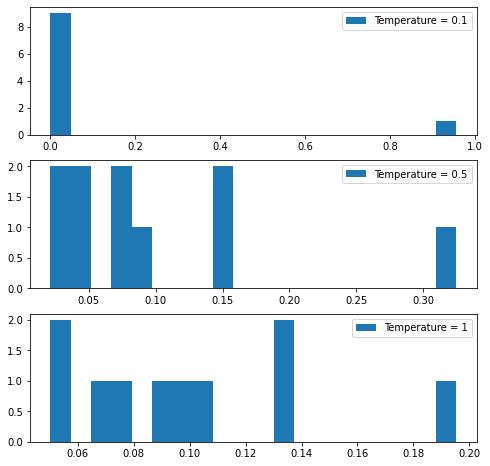

In [1]:
import numpy as np 
import seaborn as sns
from matplotlib import pyplot as plt

def reweight_distribution(original_distribution,temperature):
    distribution = np.log(original_distribution) / temperature
    distribution = np.exp(distribution)

    return distribution/np.sum(distribution)

original_distribution = np.random.uniform(0,1,size=(10,))

fig,axes = plt.subplots(3,figsize=(8,8))
temperatures = [0.1,0.5,1]

for ax,temperature in zip( axes,temperatures):
    ditribution = reweight_distribution(original_distribution,temperature)
    ax.hist(ditribution,bins=20,label=f"Temperature = {temperature}")
    ax.legend()

plt.legend()


+ Higher temperatures result in sampling distributions of higher entropy that will generate more surprising and unstructured generated data, 

+ whereas a lower temperature will result in less randomness and much more predictable generated data (

### 12.1.4 Implementing text generation with Keras

Listing 12.3 Creating a dataset from text files (one file = one sample)

In [2]:
import tensorflow as tf
from tensorflow import keras
from keras.utils import text_dataset_from_directory


dataset = text_dataset_from_directory(
    directory="E:\\Deep Learning with Python\\Datas\\Ch11_IMBD_RAW\\aclImdb_v1\\aclImdb\\",
    batch_size= 256,
    label_mode=None
)


Found 50006 files belonging to 1 classes.


In [3]:
dataset = dataset.map(lambda x: tf.strings.regex_replace(x,"<br />"," ") )

Listing 12.4 Preparing a TextVectorization layer

In [4]:
from keras import layers

sequence_length = 100
vocab_size = 15000

text_vectorization = layers.TextVectorization(
    max_tokens=vocab_size,
    output_mode="int",
    output_sequence_length=sequence_length,
     )

text_vectorization.adapt(dataset)

Listing 12.5 Setting up a language modeling dataset

In [5]:
def prepare_lm_dataset(text_batch):
    vectorized_sequence = text_vectorization(text_batch)
    ## Inputs:Cutting off the last word
    x = vectorized_sequence[:,:-1]
    ## Targets : offsetting the sequnce by 1
    y = vectorized_sequence[:,1:]
    return x,y

In [6]:
lm_dataset = dataset.map(prepare_lm_dataset,num_parallel_calls=4)

In [7]:
lm_dataset

<ParallelMapDataset element_spec=(TensorSpec(shape=(None, 99), dtype=tf.int64, name=None), TensorSpec(shape=(None, 99), dtype=tf.int64, name=None))>

#### A TRANSFORMER-BASED SEQUENCE-TO-SEQUENCE MODEL

+ We’ll train a model to predict a probability distribution over the next word in a sentence, given a number of initial words.

+ It is redundant: takes as input a sequence of N words and simply predicts word N+1
    1. The model would only learn to produce predictions when N words were available, but it would be useful to be able to start predicting with fewer than N words

    2. Second, many of our training sequences will be mostly overlapping.

+ Address two issue above: __sequnence-to-sequence__ model.

+ We’ll use causal masking to make sure that, for any $i$, the model will only be using words from $0$ to $i$ in order to predict the word $i + 1$




Listing 12.6 A simple Transformer-based language model

In [8]:
class TransformerDecoder(layers.Layer):
    def __init__(self,embed_dim,dense_dim,num_heads,**kwargs):
        super().__init__(**kwargs)

        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads

        self.attention_1 = layers.MultiHeadAttention(
            num_heads=num_heads,key_dim=embed_dim)
        self.attention_2 = layers.MultiHeadAttention(
            num_heads=num_heads,key_dim=embed_dim)
        self.dense_proj = keras.Sequential([
            layers.Dense(dense_dim,activation="relu"),
            layers.Dense(embed_dim,),
            
        ])

        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()
        self.layernorm_3 = layers.LayerNormalization()

        ##layers.Layer.support_masking

        # This attribute ensures that the layer will 
        # propagate its input mask to its outputs; 
        # masking in Keras is explicitly opt-in. If 
        # you pass a mask to a layer that doesn’t 
        # implement compute_mask() and that 
        # _ doesn’t expose this supports_masking 
        # attribute, that’s an error.
        self.supports_masking = True

    def get_config(self):
        config = super().get_config()
        config.update({
            "embed_dim" : self.embed_dim,
            "num_heads": self.num_heads,
            "dense_dim":self.dense_dim,
        })

        return config
    
    def get_causal_attention_mask(self,inputs):
        input_shape = tf.shape(inputs)
        batch_size , sequence_length = input_shape[0],input_shape[1]
        i = tf.range(sequence_length)[:,tf.newaxis]
        j = tf.range(sequence_length)

        mask = tf.cast(i >= j,dtype="int32")
       
        mask = tf.reshape(mask,(1,input_shape[1],input_shape[1]))

        ## mult = [[batch_size,1],
        #             [1,1]]
        mult = tf.concat(
            [tf.expand_dims(batch_size,-1),
                tf.constant([1,1],dtype=tf.int32,)
            ],axis=0
        )

        return tf.tile(mask,mult)
        ## It will repeat mask for batch_size times.
        ## The shape will be like shape= ( batch_size,(mask.shape),1,1,1 )


    def call(self,inputs,encoder_outputs,mask=None):
        causal_mask = self.get_causal_attention_mask(inputs)

        if mask is not  None:
            padding_mask = tf.cast( mask[:,tf.newaxis,:],dtype="int32" )
            padding_mask = tf.minimum(padding_mask,causal_mask)
        
        attent_output_1 = self.attention_1(
            query = inputs,
            value = inputs,
            key = inputs,
            # Causal_mask to restrict by N not N+1
            attention_mask = causal_mask
        )

        ## Residual & Normalization
        attent_output_1 = self.layernorm_1(inputs+attent_output_1)

        attent_output_2 = self.attention_2(
            query = attent_output_1,
            value = encoder_outputs,
            key = encoder_outputs,
            ## padding_mask make sure the previous restriction and the function of padding
            attention_mask = padding_mask,
        )

        ## Residual & Normalization
        attent_output_2 = self.layernorm_2(attent_output_1+attent_output_2)

        ## Two dense layers
        proj_output = self.dense_proj(attent_output_2)

        ##the 3rd layernormalization & Residual 
        return self.layernorm_3(proj_output + attent_output_2)



In [9]:
class PositionalEmbedding(layers.Layer):
    def __init__(self,sequence_length,input_dim,output_dim, **kwargs):
        super().__init__(**kwargs)

        # Embedding for words
        self.token_embeddings = layers.Embedding(input_dim=input_dim,output_dim=output_dim)

        #Embedding for positions
        self.position_embeddings = layers.Embedding(input_dim=sequence_length,output_dim=output_dim)

        self.sequence_length = sequence_length
        self.input_dim = input_dim
        self.output_dim = output_dim
    
    def call(self,inputs):
        length = tf.shape(inputs)[-1]
        positions = tf.range(start=0,limit=length,delta=1)
        embedded_tokens =self.token_embeddings(inputs)
        embedded_positions = self.position_embeddings(positions)
        return embedded_tokens+embedded_positions
    
    def compute_mask(self,inputs,mask=None):
        return tf.math.not_equal(inputs,0)


    def get_config(self):
        config = super().get_config()
        config.update({
                "output_dim":self.output_dim,
                "input_dim":self.input_dim,
                "sequence_length":self.sequence_length
        })
        return config




In [10]:
embed_dim =256
latent_dim =2048
num_heads = 2
sequence_length = 600
vocab_size = 20000
dense_dim = 32

inputs = keras.Input(shape=(None,),dtype="int64")
x = PositionalEmbedding(sequence_length,vocab_size,embed_dim)(inputs)
x = TransformerDecoder(embed_dim,dense_dim,num_heads)(x,x)
outputs = layers.Dense(vocab_size,activation="softmax")(x)


model  = keras.Model(inputs,outputs)
model.compile(
    optimizer=keras.optimizers.RMSprop(),
    loss = keras.losses.SparseCategoricalCrossentropy(),

)

### 12.1.5 A text-generation callback with variable-temperature sampling

We’ll use a callback to generate text using a range of different temperatures after
every epoch. 

This allows you to see how the generated text evolves as the model
begins to converge, as well as the impact of temperature in the sampling strategy

In [11]:
import numpy as np 

tokens_index = dict(enumerate(text_vectorization.get_vocabulary()))

def sample_next(predictions, temperature = 1):
    predictions = np.asarray(predictions).astype("float64")
    predictions = np.log(predictions)/temperature
    exp_preds = np.exp(predictions)
    predictions = exp_preds/np.sum(exp_preds)
    probas = np.random.multinomial(1,predictions,1)

    ## pass a mask to the dictionary to find the words
    return np.argmax(probas)

class TextGenerator(keras.callbacks.Callback):
    def __init__( self,
                 prompt,
                 generate_length,
                 model_input_length,
                 temperatures = (1.,),
                 print_freq = 1):
        
        self.prompt = prompt
        self.generate_length = generate_length
        self.model_input_length = model_input_length
        self.temperatures  = temperatures
        self.print_freq = print_freq

    def on_epoch_end(self,epoch,logs=None):
        if (epoch+1)% self.print_freq != 0:
            return
        for temperature in self.temperatures:
            sentence = self.prompt
            for i in range(self.generate_length):
                tokenized_sentence = text_vectorization([sentence])
                predictions = self.model(tokenized_sentence)
                next_token = sample_next(predictions[0,i,:])
                sampled_token = tokens_index[next_token]
                sentence += " "+sampled_token
            print(sentence)

prompt = "This movie"

text_gen_callback = TextGenerator(
    prompt=prompt,
    generate_length=50,
    model_input_length=sequence_length,
    temperatures=(0.2,0.5,0.7,1.0,1.5)
)

Listing 12.8 Fitting the language model

In [12]:
# model.fit(lm_dataset, epochs=3, callbacks=[text_gen_callback])

+ As you can see, a low temperature value results in very boring and repetitive text and
 can sometimes cause the generation process to get stuck in a loop. With higher temperatures, the generated text becomes more interesting, surprising, even creative

+ Example model like __GPT-3__ is a good example of what can be done with language models

+ A deep learning “language
 model,” despite its name, captures effectively none of these fundamental aspects o 
 language. __They can not communicate and act on the real world__

+ The fact that these artifacts have a statistical structure at all is a side
 effect of how humans implement language.

## 12.2 Deep Dream

+ $DeepDream$ is an __artistic image-modification__ technique that uses the representations
 learned by convolutional neural networks
 
+ The DeepDream algorithm is almost identical to the convnet filter-visualization technique introduced in  chapter 9, consisting of running a convnet in reverse:

   doing __gradient ascent__ on the input to the convnet in order to __maximize the activation of a specific filter in an upper layer of the convnet__

+ With DeepDream, you try to maximize the activation of entire layers rather
than that of a specific filter, thus mixing together visualizations of large numbers of features at once.

+ You start not from blank, slightly noisy input, but rather from an existing
image—thus the resulting effects latch on to preexisting visual patterns, distorting elements of the image in a somewhat artistic fashion.

+ The input images are processed at different scales (called octaves), which
improves the quality of the visualizations.

### 12.2.1 Implementing DeepDream in Keras

Listing 12.9 Fetching the test image

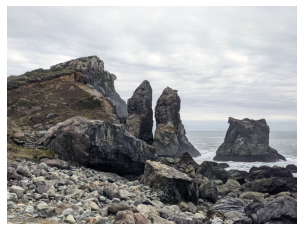

In [13]:
from tensorflow import keras
from keras.utils import get_file,load_img

base_image_path = get_file(
    "coast.jpg",origin="https://img-datasets.s3.amazonaws.com/coast.jpg"
)
plt.axis("off")
plt.imshow(load_img(base_image_path))

Next, we need a pretrained convnet. 

In Keras, many such convnets are available:
__VGG16__, __VGG19__, __Xception__, __ResNet50__, and so on, all available with weights pretrained
on __ImageNet__.

Listing 12.10 Instantiating a pretrained InceptionV3 model

In [14]:
from keras.applications import inception_v3

model = inception_v3.InceptionV3(
    weights="imagenet",include_top=False
)

+ We’ll use our pretrained convnet to __create a feature exactor model__ that __returns the activations of the various intermediate layers__, listed in the following code. 

+ For each layer, we __pick a scalar score__ that weights the contribution of the layer to the loss we will
seek to maximize during the gradient ascent process. 

If you want a complete list of layer names that you can use to pick new layers to play with, just use model.summary()

Listing 12.11 Configuring the contribution of each layer to the DeepDream loss

In [15]:
# Layers for which we try to maximize activation, as 
# well as their weight in the total loss. You can tweak 
# these setting to obtain new visual effects.
layer_settings = { 
 "mixed4": 1.5,
 "mixed5": 2.0,
 "mixed6": 2.0,
 "mixed7": 2.5, }

# Symbolic outputs 
# of each layer
outputs_dict = dict( 
 [
 (layer.name, layer.output)
 for layer in [model.get_layer(name)
 for name in layer_settings.keys()]
 ]
)

# Model that returns
# the activation values
# for every target
# layer (as a dict)
feature_extractor = keras.Model(inputs=model.inputs, outputs=outputs_dict)

Next, we’ll compute the loss: the quantity we’ll seek to maximize during the gradient ascent process at each processing scale

+ Here, we’ll simultaneously maximize the activation of all filters in a number of layers

+ Specifically, we’ll maximize a weighted mean of the L2 norm of the activations of a set of high-level layers.

Listing 12.12 The DeepDream loss

In [16]:
def compute_loss(input_image):
    features = feature_extractor(input_image)
    loss = tf.zeros(shape=())
    for name in features.keys():
        coeff = layer_settings[name]
        activation = features[name]

        #Avoid border artifcats by only involving non-border pixels in the loss
        loss += coeff*tf.reduce_mean( tf.square(activation[:,2:-2,2:-2,:])  )
    
    return loss


Now let’s set up the gradient ascent process that we will run at each octave.

It's the same thing in chapter 9

The DeepDream algorithm is simply a multiscale form of filter visualization.

Listing 12.13 The DeepDream gradient ascent process

In [17]:
@tf.function

def gradient_ascent_step(image,learning_rate):
    with tf.GradientTape() as tape:
        tape.watch(image)
        loss = compute_loss(image)

    grads = tape.gradient(loss,image)
    grads = tf.math.l2_normalize(grads)
    image += learning_rate*grads
    return loss , image

def gradient_ascent_loop(image,iterations,learning_rate,max_loss = None):
    for i in range(iterations):
        loss, image = gradient_ascent_step(image,learning_rate)
        if max_loss is not None and loss>max_loss:
            break
        
        print(f"\n Loss value at step {i} : {loss:.2f}")
    return image

1. First, we’ll define a list of scales (also called $octaves$) at which to process the images.

2. For each successive octave, from the smallest to the largest, we’ll run __20 gradient ascent steps__ via __gradient_ascent_loop()__ to maximize the loss we previously defined.

3. Between each octave, we’ll upscale the image by 40% (1.4x): we’ll start by processing a small image and then increasingly scale it up

In [18]:
step = 20
num_octave = 4
octave_scale = 1.6
iterations = 35
max_loss = 1.5

Listing 12.14 Image processing utilities

In [19]:
def preprocess_image(image_path):
    img = keras.utils.load_img(image_path)
    img = keras.utils.img_to_array(img)
    img = np.expand_dims(img,axis=0)
    img = keras.applications.inception_v3.preprocess_input(img)
    return img

def deprocess_img(img):
    img = img.reshape((img.shape[1],img.shape[2],3 ))
    
    ## Undo preprocessing of inception V3 
    img /= 2.0
    img +=0.5
    img *=255
    # Exclude all values out of [0,255]
    img = np.clip(img,0,255).astype("uint8")

    return img


To avoid losing a lot of image detail after each successive scale-up :

After each scale-up, we’ll __re-inject the lost details back into the image__, which is possible
 because we know what the original image should look like at the larger scale

this difference
 quantifies the details lost when going from S to L

Listing 12.15 Running gradient ascent over multiple successive "octaves"

In [20]:
original_img = preprocess_image(base_image_path)
original_shape = original_img.shape[1:3]

successive_shapes = [original_shape]

for i in range(1,num_octave):
    ## each dimension are regularized by the octave scale and it's order
    shape  = tuple(  [int(dim/ (octave_scale** i))  for dim in original_shape]         )
    successive_shapes.append(shape)

## Discard the last shape since it will be used, we do not need to store it
successive_shapes = successive_shapes[::-1]


shrunk_original_img = tf.image.resize(original_img,successive_shapes[0])

## Make a copy of original image, we need to keep it around
img = tf.identity(original_img)

for i , shape in enumerate(successive_shapes):
    print(f"Processing octave {i} with shape {shape}")

    img = tf.image.resize(img,shape)
    img = gradient_ascent_loop(
        img , iterations,learning_rate=step,max_loss=max_loss
    )

    ## Scale up the smaller version of the original image
    upscaled_shrunk_original_img = tf.image.resize(shrunk_original_img,shape)
    same_size_original = tf.image.resize(original_img,shape )

    ## Compute the loss of detail as we mentioned 
    lost_detail = same_size_original-upscaled_shrunk_original_img 

    ## Add it to the image
    img += lost_detail
    
    shrunk_original_img = tf.image.resize(original_img,shape)

keras.utils.save_img("Dream.png",deprocess_img(img.numpy()))




Processing octave 0 with shape (219, 292)

 Loss value at step 0 : 1.40
Processing octave 1 with shape (351, 468)

 Loss value at step 0 : 1.01
Processing octave 2 with shape (562, 750)

 Loss value at step 0 : 0.89

 Loss value at step 1 : 1.31
Processing octave 3 with shape (900, 1200)

 Loss value at step 0 : 0.91

 Loss value at step 1 : 1.29


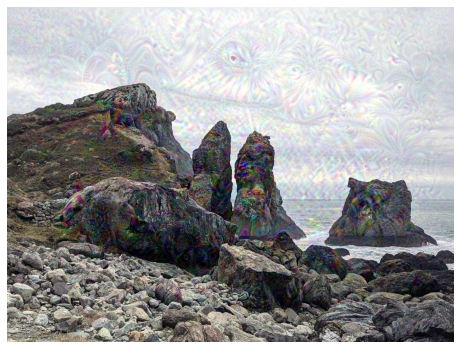

In [21]:
plt.figure(figsize=(8,8))
plt.axis("off")

plt.imshow(deprocess_img(img.numpy()))

## 12.3 Neural style transfer

+ In this context, style essentially means textures, colors, and visual patterns in the image, at various spatial scales, and the content is the higher-level macrostructure of the image.

+ The key of implemention of Style transfer: Define a __loss function__ to specify what you want to achieve, and you minimize this loss

+ The loss function :

    loss = (distance(style(reference_image) - style(combination_image)) +
                distance(content(original_image) - content(combination_image)))

+ Here, $distance$ is a __norm function such as the L2 norm__, content is a function that
 takes an image and computes a representation of its content, and $style$ is a function
 that takes an image and computes a __representation of its style__


### 12.3.1 The content loss

+ $Activations$ from earlier layers in a network contain local information about the image, whereas activations from higher layers contain increasingly global, abstract information.

+ Therefore, you’d expect the content of an image, which is
 __more global and abstract__, to be captured by the representations of the upper layers in
 a convnet

+ A good candidate for content loss is thus the L2 norm between the activations o 
 an upper layer in a pretrained convnet, computed over the target image, and the activations of the same layer computed over the generated image. 

+ L2 norm guarantees the generated image will look similar to the original target image. 

### 12.3.2 The style loss

+ Preserve __content__ by maintaining similar __high-level layer activations__ between the
 original image and the generated image. The convnet should “see” both the
 original image and the generated image as containing the same things.

+ Preserve __style__ by maintaining similar correlations within activations for __both low-level layers and high-level layers__. Feature correlations capture $textures$: the generated image and the style-reference image should share the same textures at
 different spatial scales

### 12.3.3 Neural style transfer in Keras

+ VG199 will be applied 

+ General Process:

    1. Set up a network that computes VGG19 layer activations for the style-reference
    image, the base image, and the generated image at the same time.
    
    2. Use the layer activations computed over these three images to define the loss
    function described earlier, which we’ll minimize in order to achieve style
    transfer.
    
    3. Set up a gradient-descent process to minimize this loss function

Listing 12.16 Getting the style and content images

In [22]:
base_image_path = get_file(
    "sf.jpg",
    origin="https://img-datasets.s3.amazonaws.com/sf.jpg"
)

style_reference_image_path = get_file( 
 "starry_night.jpg", 
 origin="https://img-datasets.s3.amazonaws.com/starry_night.jpg")

In [23]:
original_width, original_height = keras.utils.load_img(base_image_path).size
img_height= 400
img_width = round(original_width* img_height / original_height)


Listing 12.17 Auxiliary functions

In [24]:
def preprocess_image(image_path):
    img = keras.utils.load_img(image_path,target_size=(img_height,img_width))

    img = keras.utils.img_to_array(img)
    img = np.expand_dims(img,axis = 0)
    img = keras.applications.vgg19.preprocess_input(img)
    return img

def deprocess_img(img):
    img  = img.reshape((img_height,img_width,3))
#     Zero-centering by removing the mean pixel value 
# from ImageNet. This reverses a transformation 
# done by vgg19.preprocess_input.

    img[:, :, 0] += 103.939 
    img[:, :, 1] += 116.779 
    img[:, :, 2] += 123.68 

# Converts images from 'BGR' to 'RGB'. 
# This is also part of the reversal of 
# vgg19.preprocess_input.

    img = img[:, :, ::-1]
    

    img = np.clip(img, 0, 255).astype("uint8")
    return img

Listing 12.18 Using a pretrained VGG19 model to create a feature extractor

In [25]:
model = keras.applications.vgg19.VGG19(weights='imagenet',include_top=False)
outputs_dict = dict([ 
                (layer.name,layer.output) for layer in model.layers])

feature_extractor = keras.Model(inputs = model.inputs,outputs= outputs_dict)


Listing 12.19 Content loss

In [26]:
def content_loss(base_img, combination_img):
    return tf.reduce_sum(tf.square(combination_img - base_img))
    

Listing 12.20 Style loss : $Gram Matrix$

In [27]:
def gram_matirx(x):
    x = tf.transpose(x,(2,0,1))
    features = tf.reshape(x,(tf.shape(x)[0],-1))
    gram = tf.matmul(features,tf.transpose(features))
    return gram

def style_loss(style_img,combination_img):
    S = gram_matirx(style_img)
    C = gram_matirx(combination_img)
    # R&G&B , channels = 3
    channels = 3
    size = img_height* img_width
    return tf.reduce_sum( (tf.square(S-C))/(4.0*(channels**2)*(size**2)) )
    

To these two loss components, you add a third: the $total$ $variation$ $loss$, which operates
 on the pixels of the generated combination image.

Listing 12.21 Total variation loss

In [28]:
def total_variation_loss(x):
    a = tf.square(
        x[:,:img_height-1,:img_width-1,:] - x[:,1:,:img_width-1,:]
    )

    b = tf.square(
        x[:,:img_height-1,:img_width-1,:] - x[:,:img_height-1,1:,:]
    )

    return tf.reduce_sum(tf.pow(a+b,1.25))
    

+ The loss that you minimize is a weighted __average of these three losses__

+ To compute the
 content loss, you use only one upper layer—the __block5_conv2__ layer—whereas for the
 style loss, you use a list of layers that spans both low-level and high-level layers


Listing 12.22 Defining the final loss that you’ll minimize

In [29]:
style_layer_names = [ 
 "block1_conv1",
 "block2_conv1",
 "block3_conv1",
 "block4_conv1",
 "block5_conv1", ]

content_layer_name = "block5_conv2" 
total_variation_weight = 1e-6

style_weight = 1e-6 
content_weight = 2.5e-8

def compute_loss(combination_image,base_image,style_reference_image):
    input_tensor = tf.concat(
        [base_image,style_reference_image,combination_image],axis=0
    )


    ## Computing the content loss
    # Extract all the features of all the layers
    features = feature_extractor(input_tensor)
    loss = tf.zeros(shape=())
    layer_features =features[content_layer_name]
    base_image_features = layer_features[0,:,:,:]
    combination_features = layer_features[2,:,:,:]
    loss = loss+ content_weight * content_loss(
        base_image_features , combination_features)

    ## Computing style loss
    for layer_name in style_layer_names:

        layer_features = features[layer_name]

        style_reference_features  = layer_features[1,:,:,:]
        combination_features = layer_features[2,:,:,:]

        style_loss_value=  style_loss(style_reference_features, combination_features)
        
        ## The weight = style_weight / len(style_layer_names)
        loss += (style_weight/len(style_layer_names)) * style_loss_value
    
    loss += total_variation_weight * total_variation_loss(combination_image)

    return loss
    

Finally, let’s set up the gradient-descent process. In the original Gatys et al. paper, optimization is performed using the $L-BFGS$ $algorithm$, but that’s not available in TensorFlow, so we’ll just do $mini-batch$ gradient descent with the $SGD$ optimizer instead

Listing 12.23 Setting up the gradient-descent process

In [30]:
import tensorflow as tf
@tf.function 
def compute_loss_and_grads(
 combination_image, base_image, style_reference_image):
    with tf.GradientTape() as tape:
        loss = compute_loss(
            combination_image, base_image, style_reference_image)
    grads = tape.gradient(loss, combination_image)
    
    return loss, grads



In [31]:
optimizer = keras.optimizers.SGD(
 keras.optimizers.schedules.ExponentialDecay( 
 initial_learning_rate=100.0, decay_steps=100, decay_rate=0.96))


base_image = preprocess_image(base_image_path)
style_reference_image = preprocess_image(style_reference_image_path)
combination_image = tf.Variable(preprocess_image(base_image_path)) 


iterations = 1000


for i in range(1, iterations + 1): 
    loss, grads = compute_loss_and_grads(
    combination_image, base_image, style_reference_image)

    optimizer.apply_gradients([(grads, combination_image)]) 
    
    if i % 1000 == 0:
        print(f"Iteration {i}: loss={loss:.2f}")
        img = deprocess_img(combination_image.numpy())
        fname = f"combination_image_at_iteration_{i}.png"
        keras.utils.save_img(fname, img)

Iteration 1000: loss=5068.93


## 12.4 Generating images with variational autoencoders

+ $Variational$ $Autoencoders$ (VAEs) 
+ $Generative$ $Adversarial$ $Networks$(GANs)

### 12.4.1 Sampling from latent spaces of images

+ The key idea of image generation is to develop a __low-dimensional latent space of representations__

+ The module capable of realizing this mapping, taking as input a latent point and outputting an image (a grid of pixels), 
    + is called a $generator$ (in the case of $GANs$) or 
    + is called a $decoder$ (in the case of $VAEs$).

+ Once such a latent space has been learned, you can sample
 points from it, and, by mapping them back to image space, generate images that have
 never been seen before.

+ Difference between $VAE$ and $GAN$:
  + $VAE$ : Great for learning __latent spaces that are well structured__, where specific directions encode a meaningful         
            axis of variation in the data.

  + $GAN$ : Poentially be highly realistic, but the __latent space__ they come from may __not have as much structure and continuity__.

### 12.4.2 Concept vectors for image editing

+ Idea : Given a latent space of representations, or an embedding space, certain directions in the space may __encode interesting  axes of variation__ in the original data.

+ Example :  $smile$ $vector$,  if __latent point z__ is the embedded representation of a certain
 face, then latent point z + s is the embedded representation of the same face, smiling




### 12.4.3 Variational Auto Encoders

+ A kind of generative model that’s especially appropriate for the task of image editing via concept vectors

+ They’re a modern take on autoencoders (a type of network that aims to encode an input to a low-dimensional latent space and then decode it back) that
 mixes ideas from deep learning with Bayesian inference.

+ A classical image autoencoder : 
    + use __same images__ as targets to learn
    + Constrain code to be low-dimensional and sparse.
    + Useless in partcise.

+ A Vairational AutoEncoder: 
    +  turns the image into the parameters of a statistical distribution: __a Mean and a Variance__.
    +  How it works : 
        1. An encoder module turns the input sample, input_img, into two parameters in a latent space of representations, z_mean and z_log_variance. 
        2. You randomly sample a point z from the latent normal distribution that’s assumed to generate the input image,
            
             via z = z_mean + exp(z_log_variance) *epsilon, where epsilon is a random tensor of small values.
        3. A decoder module maps this point in the latent space back to the original input image.

+ Because __epsilon__ is random, the process ensures that every point that’s close to the
 latent location where you encoded input_img (z-mean) can __be decoded to something similar to input_img__, thus forcing the latent space to be continuously meaningful.

+ Continuity,
 combined with the __low dimensionality of the latent space__, forces every direction in the
 latent space to encode a meaningful axis of variation of the data, making the latent
 space very structured and thus highly suitable to manipulation via concept vectors


+ Two loss functions:
    1. $Reconstruction$ $loss$ : forces the decoded samples to match the initial inputs
    
    2. $Regularization$ $loss$ : helps learn well-rounded latent distributions and reduces overfitting to the training data

z_mean, z_log_variance = encoder(input_img) 


z = z_mean + exp(z_log_variance) * epsilon 

reconstructed_img = decoder(z) 

model = Model(input_img, reconstructed_img)

For the $regularization$ $loss$, we typically use an expression (the Kullback–Leibler divergence) meant to nudge the distribution of the encoder output toward a __well-rounded normal distribution centered around 0__. 

### 12.4.4 Implementing a VAE with Keras

We’re going to be implementing a VAE that can generate MNIST digits. It’s going to
have three parts:
1. An encoder network that turns a real image into a mean and a variance in the
latent space

2. A sampling layer that takes such a mean and variance, and uses them to sample
a random point from the latent space

3. A decoder network that turns points from the latent space back into images


Listing 12.24 VAE encoder network

In [32]:

## Latent dim means it's a 2D place
latent_dim = 2

encoder_inputs = keras.Input(shape=(28,28,1))
x= layers.Conv2D(
    32,3,activation='relu',strides=2,padding='same')(encoder_inputs)

x = layers.Conv2D(64,3,activation='relu',strides=2,padding='same')(x)
x = layers.Flatten()(x)
x = layers.Dense(16,activation='relu')(x)

z_mean = layers.Dense(latent_dim,name="z_mean")(x)
z_log_var = layers.Dense(latent_dim,name="z_log_var")(x)
encoder = keras.Model(encoder_inputs,[z_mean,z_log_var],name = 'encoder')



In [33]:
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 conv2d_94 (Conv2D)             (None, 14, 14, 32)   320         ['input_4[0][0]']                
                                                                                                  
 conv2d_95 (Conv2D)             (None, 7, 7, 64)     18496       ['conv2d_94[0][0]']              
                                                                                                  
 flatten (Flatten)              (None, 3136)         0           ['conv2d_95[0][0]']              
                                                                                            

Listing 12.25 Latent-space-sampling layer

In [34]:
import tensorflow as tf 

class Sampler(layers.Layer):
    def call(self,z_mean,z_log_var):
        batch_size = tf.shape(z_mean)[0]
        z_size = tf.shape(z_mean)[1]
        epsilon = tf.random.normal(shape=(batch_size,z_size))
        
        return z_mean+tf.exp(0.5* z_log_var) * epsilon

Listing 12.26 VAE decoder network, mapping latent space points to images

In [35]:
# Input we will feed z_mean and z_log_var
latent_inputs = keras.Input(shape=(latent_dim,))

# Notice that conv2d_193 (Conv2D) == (None, 7, 7, 64)
# We need to produce same number of coeffients that we had at the level of the flatten layer in the encoder 
x = layers.Dense(7*7*64,activation='relu')(latent_inputs)
x = layers.Reshape((7,7,64))(x)

x = layers.Conv2DTranspose(64,3,activation='relu',strides=2,padding='same')(x)
x = layers.Conv2DTranspose(32,3,activation='relu',strides=2,padding='same')(x)

decoder_outputs = layers.Conv2D(1,3,activation='sigmoid',padding='same')(x)
decoder = keras.Model(latent_inputs,decoder_outputs,name= 'decoder')

In [36]:
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 2)]               0         
                                                                 
 dense_4 (Dense)             (None, 3136)              9408      
                                                                 
 reshape (Reshape)           (None, 7, 7, 64)          0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 14, 14, 64)       36928     
 nspose)                                                         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 28, 28, 32)       18464     
 ranspose)                                                       
                                                                 
 conv2d_96 (Conv2D)          (None, 28, 28, 1)         289 

+ This is your first $self-supervised$ learning model

+ It's common to write a custom __fit()__ method for that cases

Listing 12.27 VAE model with custom train_step()

In [37]:
from keras import Model
class VAE(Model):
    def __init__(self,encoder,decoder,**kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.sampler = Sampler()
        self.total_loss_tracker = keras.metrics.Mean(name= 'total_loss')
        self.reconstruction_loss_tracker = keras.metrics.Mean(name="reconstructer_loss")
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")


    @property

    def metrics(self):
        return[
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker
        ]

    def train_step(self,data):
        with tf.GradientTape() as tape:
            z_mean,z_log_var = self.encoder(data)
            z = self.sampler(z_mean,z_log_var)
            reconstruction = decoder(z)
            reconstruction_loss = tf.reduce_mean(
                                    tf.reduce_sum(
                                        keras.losses.binary_crossentropy(data,reconstruction),axis=(1,2)
                                    )
            )
            kl_loss = -0.5* (1+z_log_var-tf.square(z_mean)-tf.exp(z_log_var))
            total_loss = reconstruction_loss+kl_loss
        
        grads = tape.gradient(total_loss,self.trainable_weights)

        self.optimizer.apply_gradients(zip(grads,self.trainable_weights))
        
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)

        return {
            "total_loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

Listing 12.28 Training the VAE

In [38]:
import numpy as np 

from keras.datasets import mnist

(X_train,_),(X_test,_) = mnist.load_data()
mnist_digits = np.concatenate([X_train,X_test],axis=0)
print(mnist_digits.shape)
## Expand the tensor to make sure the color vector is conserved
mnist_digits = np.expand_dims(mnist_digits,axis=-1).astype('float32')/255
print(mnist_digits.shape)

vae = VAE(encoder,decoder)
vae.compile(
    ## If run_eagerly = True, the model's logic will not be wrapped in a tf.function
    optimizer=keras.optimizers.Adam(),run_eagerly=True
)
##Note that there is no loss function in the compile. 



(70000, 28, 28)
(70000, 28, 28, 1)


In [39]:
vae.fit(mnist_digits,epochs=15,batch_size=128,verbose = 0)
## We can learn that the property .train_step(self,data) will be called when use .fit method
## The batch_size para is only vaild for the .fit() method to batch the data, it will not be passed to the model class.


Listing 12.29 Sampling a grid of images from the 2D latent space


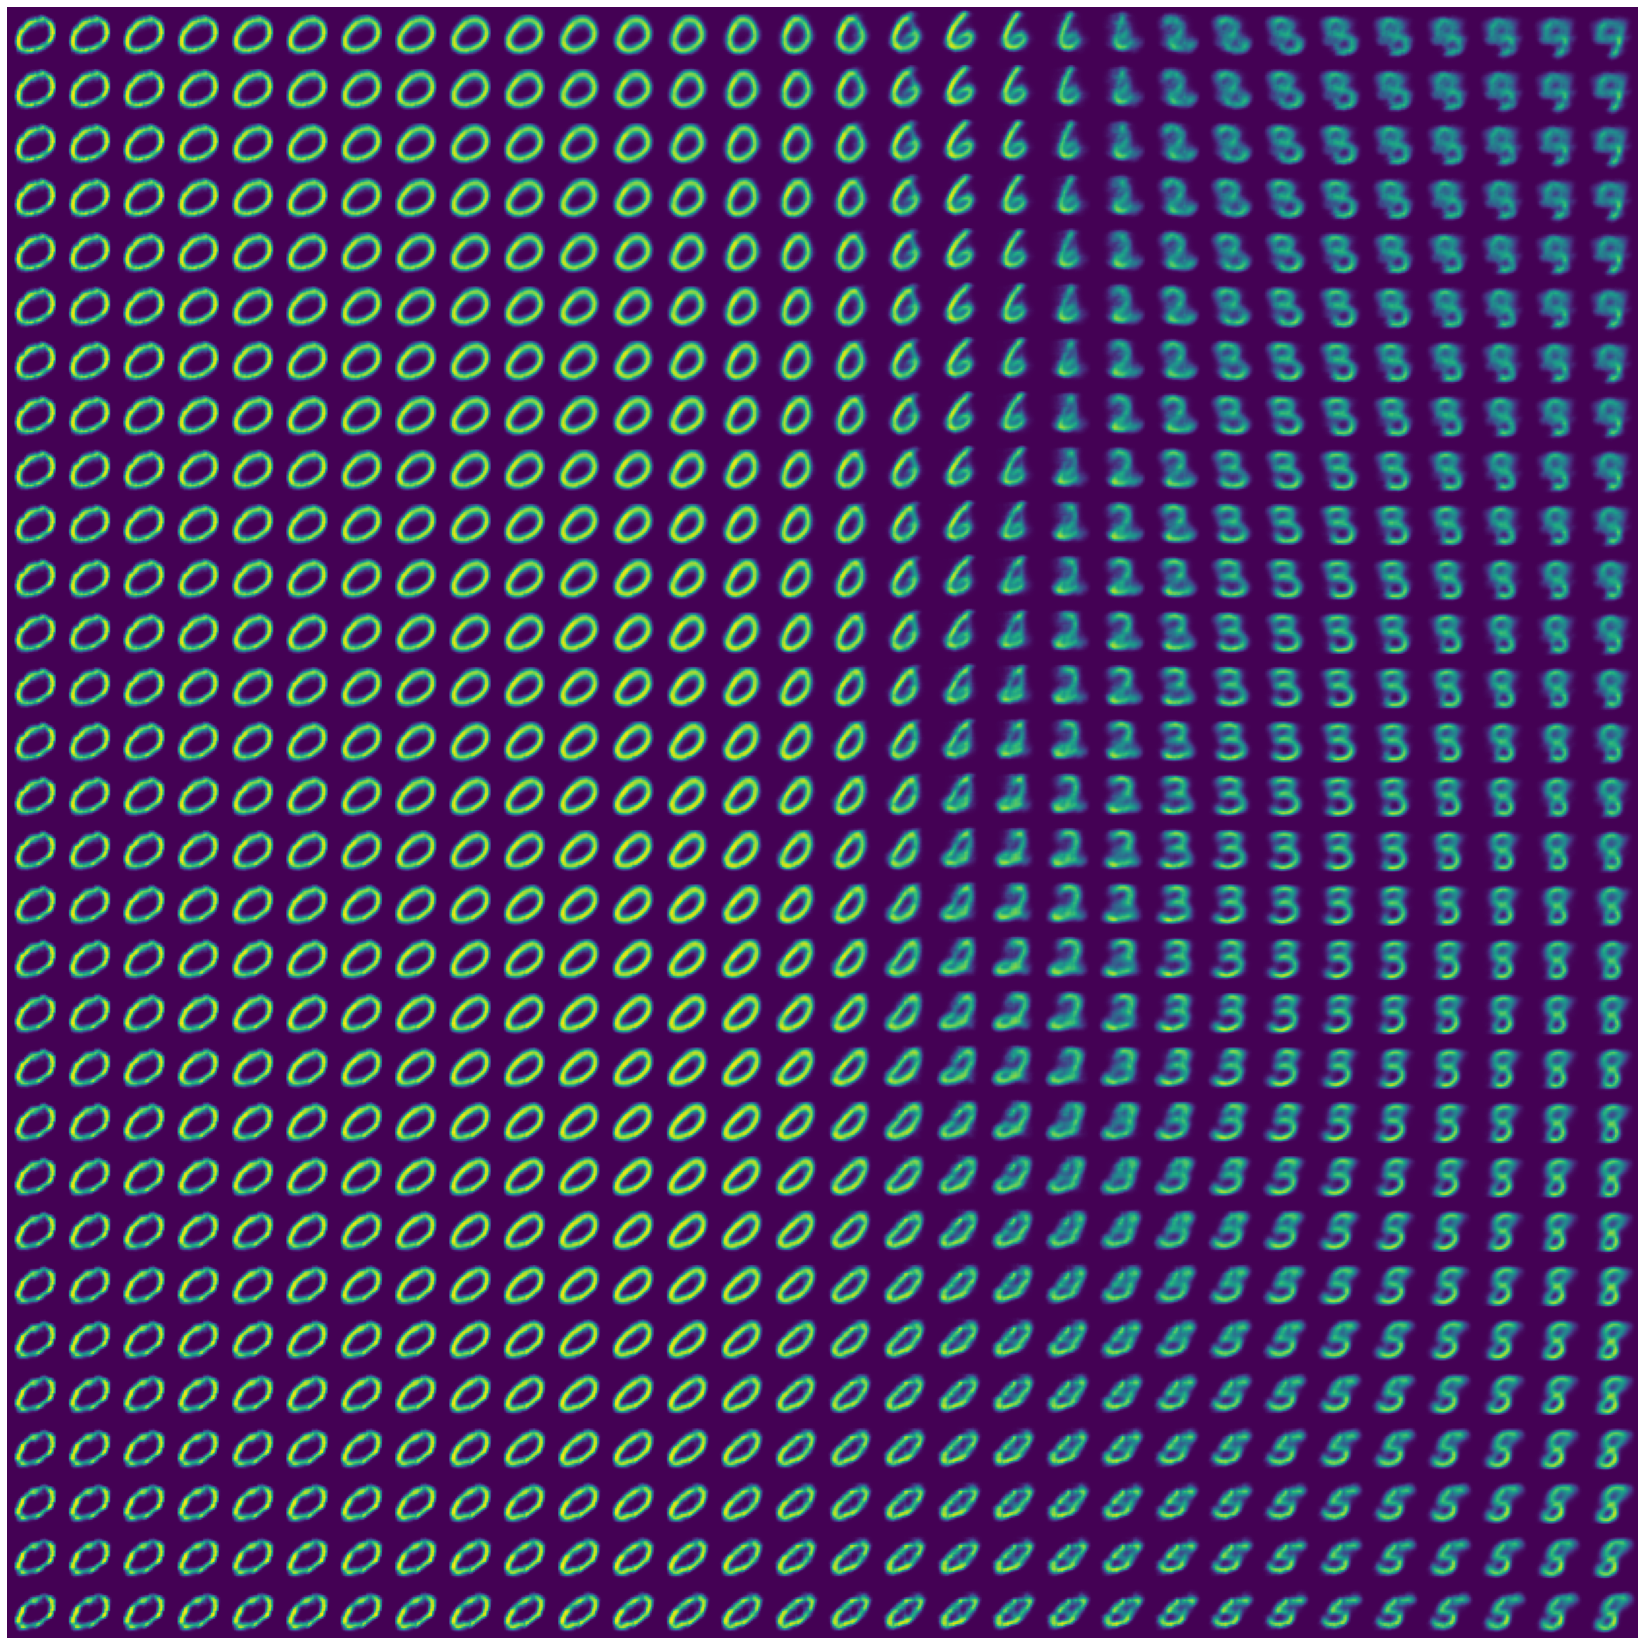

In [40]:
n= 30 
digit_size = 28
figure = np.zeros((digit_size*n,digit_size*n))

grid_x = np.linspace(-1,1,n)
# y is the reverse of x
grid_y = np.linspace(-1,1,n)[::-1]

for i, yi in enumerate(grid_y):
    for j, xi in enumerate(grid_x):
        z_sample = np.array([[xi,yi]])
        x_decoded = vae.decoder.predict(z_sample,verbose = 0)
        digit = x_decoded[0].reshape(digit_size,digit_size)
        figure[
            i*digit_size : (i+1)*digit_size,
            j*digit_size : (j+1)*digit_size,
        ] = digit
    
plt.figure(figsize=(30,30))
start_range = digit_size//2
end_range = n*digit_size + start_range

pixel_range = np.arange(start_range,end_range,digit_size)
sample_range_x = np.round(grid_x,1)
sample_range_y = np.round(grid_y,1)

plt.xticks(pixel_range,sample_range_x)
plt.yticks(pixel_range,sample_range_y)
plt.xlabel("z[0]")
plt.ylabel("z[1]")
plt.axis("off")
plt.imshow(figure,cmap="viridis")
plt.show()

### 12.4.5 Wrapping up
1. Image generation with deep learning is done by learning latent spaces that capture statistical information about a dataset of images. By sampling and decoding points from the latent space, you can generate never-before-seen images.

There are two major tools to do this: VAEs and GANs.


2. VAEs result in highly structured, continuous latent representations. For this reason, they work well for doing all sorts of image editing in latent space: face
 swapping, turning a frowning face into a smiling face, and so on. They also work
 nicely for doing latent-space-based animations, such as animating a walk along a
 cross section of the latent space or showing a starting image slowly morphing
 into different images in a continuous way.


3. GANs enable the generation of realistic single-frame images but may not induce
 latent spaces with solid structure and high continuity.

## 12.5 Introduction to Generative Adversarial Networks (GAN)

+ They enable the generation of fairly realistic synthetic images by forcing the generated images to be statistically almost indistinguishable from real ones.

+ GAN: Being trained to be excellent to each other.

+ Two parts of GAN :
    1. $Generator$ $network$ —Takes as input a random vector (a random point in the latent space), and decodes it into a synthetic image

    2. $Discriminator$ $network$ (or adversary)—Takes as input an image (real or synthetic),
 and predicts whether the image came from the training set or was created by
 the generator network

+ The $generator$ network is trained to be able to fool the discriminator network, and
 thus it evolves toward generating increasingly realistic images as training goes on

+ The $discriminator$ is constantly adapting to the gradually improving capabilities of the
 generator, setting a high bar of realism for the generated images


+ Remarkably, a GAN is a system where the __optimization minimum isn’t fixed__

+ It's a dynamic system which searchs for __equilibrium__ NOT minimum, which made GAN is hard to train and adjust the parameters

### 12.5.1 A schematic GAN implementation

+ we’ll use in this demonstration is a $Deep$ $Convolutional$ $GAN$ $(DCGAN)$: a very basic GAN where the generator and discriminator are deep convnets.

+ Schematically, the GAN looks like this:


 1. A generator network maps vectors of shape __(latent_dim,)__ to images of shape
 __(64, 64, 3)__.  
 
 
 2. A discriminator network maps images of shape __(64, 64, 3)__ to a __binary score__
 estimating the probability that the image is real.
 
 3. A gan network chains the generator and the discriminator together: __gan(x) = discriminator(generator(x))__. Thus, this gan network maps latent space vectors to the discriminator’s assessment of the realism of these latent vectors as
 decoded by the generator.
 

 4. We train the discriminator using examples of real and fake images along with
 __“real”/“fake”__ labels, just as we train any regular image-classification model.
 

 
 5. To train the generator, we use the __gradients of the generator’s weights with regard to the loss of the gan model__. This means that at every step, we move the
 weights of the generator in a direction that makes the discriminator more likely
 to classify as “real” the images decoded by the generator. In other words, we
 train the generator to fool the discriminator.

### 12.5.2 A bag of tricks

1. We use __strides__ instead of pooling for downsampling feature maps in the discriminator, just like we did in our VAE encoder.
 
2. We sample points from the latent space using a __normal distribution__ (Gaussian distribution), not a uniform distribution.

3. Stochasticity is good for inducing robustness. Because GAN training results in a
 dynamic equilibrium, GANs are likely to get stuck in all sorts of ways. Introducing randomness during training helps prevent this. We introduce randomness
 by __adding random noise to the labels__ for the discriminator.

4. Sparse gradients can hinder GAN training. In deep learning, __sparsity is often a desirable property, but not in GANs__. Two things can induce gradient sparsity:

    + max pooling operations and relu activations. Instead of max pooling, we recommend using strided convolutions for downsampling
    + we recommend using a __LeakyReLU__ layer instead of a relu activation. It’s similar to relu, but it relaxes sparsity constraints by allowing small negative activation values.



5. In generated images, it’s common to see checkerboard artifacts caused by
 unequal coverage of the pixel space in the generator To fix
 this, we use a __kernel size that’s divisible by the stride size__ whenever we use a
 strided Conv2DTranspose or Conv2D in both the generator and the discriminator.

### 12.5.3 Getting our hands on the CelebA dataset

Listing 12.31 Creating a dataset from a directory of images

In [68]:
from keras.utils import image_dataset_from_directory
dataset = image_dataset_from_directory(
    directory="E:\\Deep Learning with Python\\Datas\\Ch12_GAN\\img_align_celeba\\img_align_celeba\\",
    label_mode=None,
    image_size=(64,64),
    batch_size= 32,
    smart_resize = True
)

Found 202599 files belonging to 1 classes.


Listing 12.32 Rescaling the images

In [69]:
dataset = dataset.map(lambda x : x/255.)


Listing 12.33 Displaying the first image

(32, 64, 64, 3)


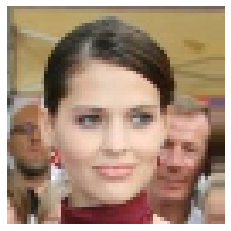

In [70]:
for x in dataset:
    plt.axis("off")
    print(x.shape)
    plt.imshow((x.numpy()*255).astype('int32')[1] )
    break

### 12.5.4 The discriminator

Listing 12.34 The GAN discriminator network

In [71]:
discriminator = keras.Sequential([
    keras.Input(shape=(64,64,3)),
    layers.Conv2D(64,kernel_size=4,strides=2,padding="same"),
    layers.LeakyReLU(alpha=0.2),
    layers.Conv2D(128,kernel_size=4,strides=2,padding="same"),
    layers.LeakyReLU(alpha=0.2),
    layers.Conv2D(128,kernel_size=4,strides=2,padding="same"),
    layers.LeakyReLU(alpha=0.2),
    layers.Flatten(),
    layers.Dropout(0.2),
    layers.Dense(1,activation="sigmoid"),
    ], name = "discriminator")

In [72]:
discriminator.summary()

Model: "discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_102 (Conv2D)         (None, 32, 32, 64)        3136      
                                                                 
 leaky_re_lu_9 (LeakyReLU)   (None, 32, 32, 64)        0         
                                                                 
 conv2d_103 (Conv2D)         (None, 16, 16, 128)       131200    
                                                                 
 leaky_re_lu_10 (LeakyReLU)  (None, 16, 16, 128)       0         
                                                                 
 conv2d_104 (Conv2D)         (None, 8, 8, 128)         262272    
                                                                 
 leaky_re_lu_11 (LeakyReLU)  (None, 8, 8, 128)         0         
                                                                 
 flatten_2 (Flatten)         (None, 8192)            

### 12.5.5 The generator

Listing 12.35 GAN generator network

In [73]:

latent_dim = 128

generator = keras.Sequential([
    keras.Input(shape=(latent_dim,)),
    ## Corresponds to the discrimator
    layers.Dense(8*8*128),
    layers.Reshape((8,8,128)),
    layers.Conv2DTranspose(128,4,strides=2,padding='same'),
    layers.LeakyReLU(0.2),
    layers.Conv2DTranspose(256,4,strides=2,padding='same'),
    layers.LeakyReLU(0.2),
    layers.Conv2DTranspose(512,4,strides=2,padding='same'),
    layers.LeakyReLU(0.2),
    # 3 channels of color,
    layers.Conv2D(3,5,padding='same',activation="sigmoid"),

],name="generator")

In [74]:
generator.summary()

Model: "generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_9 (Dense)             (None, 8192)              1056768   
                                                                 
 reshape_3 (Reshape)         (None, 8, 8, 128)         0         
                                                                 
 conv2d_transpose_8 (Conv2DT  (None, 16, 16, 128)      262272    
 ranspose)                                                       
                                                                 
 leaky_re_lu_12 (LeakyReLU)  (None, 16, 16, 128)       0         
                                                                 
 conv2d_transpose_9 (Conv2DT  (None, 32, 32, 256)      524544    
 ranspose)                                                       
                                                                 
 leaky_re_lu_13 (LeakyReLU)  (None, 32, 32, 256)       0 

### 12.5.6 The adversarial network

For each epoch, you do the following:
1. Draw random points in the latent space (random noise).

2. Generate images with generator using this random noise.

3. Mix the generated images with real ones.

4. Train discriminator using these mixed images, with corresponding targets: either “real” (for the real images) or “fake” (for the generated images).

5. Draw new random points in the latent space.
 
6. Train generator using these random vectors, with targets that all say “these are
 real images.” This updates the weights of the generator to move them toward
 getting the discriminator to predict “these are real images” for generated
 images: this trains the generator to fool the discriminator.

Listing 12.36 The GAN Model

In [79]:
class GAN(Model):
    def __init__(self,discriminator,generator,latent_dim,**kwargs):
        super().__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim
        self.d_loss_metric = keras.metrics.Mean(name = "d_loss")
        self.g_loss_metric = keras.metrics.Mean(name = "g_loss")
        
    def compile(self,d_optimizer,g_optimizer,loss_fn):
        super(GAN,self).compile()
        self.d_optimizer= d_optimizer
        self.g_optimizer= g_optimizer
        self.loss_fn = loss_fn
    
    @property
    def metrics(self):
        return [self.d_loss_metric,self.g_loss_metric]

    def train_step(self,real_images):
        batch_size = tf.shape(real_images)[0]

        ## Assemble the initial image combine real_image with noise which is under uniformed distrbution
        random_lantent_vectors = tf.random.normal(
            shape= (batch_size,self.latent_dim)
        )

        # Generate a batch of noise images, which shape =(32,64,64,3)
        generated_images = self.generator(random_lantent_vectors)

        ## Shape = (64,64,64,3)
        combined_image = tf.concat([generated_images,real_images],axis=0)
        
        ## Initializing the labels for discriminator
        labels = tf.concat([tf.ones((batch_size,1)), tf.zeros((batch_size,1)) ], axis = 0)

        labels += 0.05 * tf.random.uniform(tf.shape(labels))

        ## Gradients for discriminator
        with tf.GradientTape() as tape:
            predictions = self.discriminator(combined_image)
            d_loss = self.loss_fn(labels,predictions)
        grads = tape.gradient(d_loss,self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(
            zip(grads, self.discriminator.trainable_weights)
        )


        random_lantent_vectors= tf.random.normal(shape= (batch_size,self.latent_dim))

        ## Assembles labels that tell these are real or not
        misleading_labels = tf.zeros((batch_size,1))

        ## Gradients for generator
        with tf.GradientTape() as tape:
            predictions = self.discriminator(self.generator(random_lantent_vectors))
            g_loss = self.loss_fn(misleading_labels,predictions)
        
        grads =tape.gradient(g_loss,self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(
            zip(grads,self.generator.trainable_weights)
        )

        self.d_loss_metric.update_state(d_loss)
        self.g_loss_metric.update_state(g_loss)

        return {
            "g_loss": self.g_loss_metric.result(),
            "d_loss": self.d_loss_metric.result(),
                }





Before start, let's set up a callback to monitor results

Listing 12.37 A callback that samples generated images during training

In [80]:
from keras.callbacks import Callback

class GANMonitor(Callback):
    def __init__(self,num_img = 3,latent_dim = 128):
        self.num_img = num_img
        self.latent_dim = latent_dim
    
    def one_epoch_end(self,epoch,logs = None):
        random_latent_vectors = tf.random.normal((self.num_img,self.latent_dim))
        generated_images = self.model.generator = (random_latent_vectors)
        generated_images *=255
        generated_images.numpy()

        for i in range(self.num_img):
            img =  keras.utils.array_to_img(generated_images[i])
            img.save("E:\\Python-Machine-Learning\\Deep_Learning_With_python\\Ch12_GAN\\generated_img_{:.03d}_{}.jpg ".format(epoch,i))
            


Listing 12.38 Compiling and training the GAN

In [81]:
epochs = 100

gan = GAN(discriminator=discriminator,generator=generator,latent_dim=latent_dim)

gan.compile(
    d_optimizer=keras.optimizers.Adam(learning_rate=1e-4),
    g_optimizer=keras.optimizers.Adam(learning_rate=1e-4),
    loss_fn= keras.losses.BinaryCrossentropy()
)

In [83]:
# gan.fit(dataset,epochs=epochs,callbacks=[GANMonitor(num_img=10,latent_dim=latent_dim)])

### 12.4.11  Summary 
1. the discriminator. Remarkably, the generator never sees images from the training
 set directly; the information it has about the data comes from the discriminator.
 
2. GANs are difficult to train, because training a GAN is a dynamic process rather
 than a simple gradient descent process with a fixed loss landscape. Getting a
 GAN to train correctly requires using a number of heuristic tricks, as well as
 extensive tuning.

3. GANs can potentially produce highly realistic images. But unlike VAEs, the
 latent space they learn doesn’t have a neat continuous structure and thus may
 not be suited for certain practical applications, such as image editing via latent space concept vectors.

## Summary
+ You can use a sequence-to-sequence model to generate sequence data, one step
at a time. This is applicable to text generation, but also to note-by-note music
generation or any other type of timeseries data.


+ DeepDream works by maximizing convnet layer activations through gradient
ascent in input space.


+ In the style-transfer algorithm, a content image and a style image are combined
together via gradient descent to produce an image with the high-level features
of the content image and the local characteristics of the style image.

+ VAEs and GANs are models that learn a latent space of images and can then
dream up entirely new images by sampling from the latent space. Concept vectors
in the latent space can even be used for image editing.